In [1]:
import datetime
import smtplib
from email.mime.text import MIMEText
import QUANTAXIS as QA

try:
    assert QA.__version__ >= '1.1.0'
except AssertionError:
    print('pip install QUANTAXIS >= 1.1.0 请升级QUANTAXIS后再运行此示例')
    import QUANTAXIS as QA
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import abupy
from abupy import ABuRegUtil
from concurrent.futures import ThreadPoolExecutor
from functools import reduce
import warnings
import re
read_dictionary = np.load('/media/sf_GIT/vest/liutong.npy', allow_pickle=True).item()
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.ticker as mtk
import mpl_finance as mpf
index = 'datetime'
formate = '%Y-%m-%dT%H:%M:%S'
dayindex = 'date'
dayformate = '%Y-%m-%d'
startday='2018-01-01'

pw=0.47  #backtest win ratio
rw=1.15 #sell when got 15% increase
rl=0.97 #end if loss 0.03 of holdings
def percSet(pw,rw,rl):
    #kelly rule of holdings
    return (pw/rl)-(1-pw)/rw
#percSet(pw,rw,rl)


def initData(sample):
    sample['EMA13'] = QA.EMA(sample.close, 13)
    #sample['EMA26'] = QA.EMA(sample.close,26)
    sample['MA64'] = QA.MA(sample.close,64)
    sample['MA256'] = QA.MA(sample.close,256)
    pp_array = [x for x in sample.close]
    forceweight =[]
    force = [0]
    for m,n in zip(pp_array[:-1],pp_array[1:]):
        force.append(n-m)
        #print (n-m)
    #only for online data. is sample.vol, datat
    volumn = [x for x in sample.volume]
    for x,y in zip(force,volumn):
        #print("{0} and {1}".format(x,y))
        forceweight.append(x*y)

    sample['FORCE']=forceweight
    sample['FCEMA2']=QA.EMA(sample.FORCE,2)
    sample['FCEMA13']=QA.EMA(sample.FORCE,13)
    #print(sample)
    rate = 0.015
    sample['EMA12'] = QA.EMA(sample.close, 12)
    sample['EMA5']=QA.EMA(sample.close,5)
    #sample['MA64']=QA.MA(sample.close,64)
    #sample['MA256']=QA.MA(sample.close,256)
    sample['EMA20']=QA.EMA(sample.close,20)
    sample['k1'] = 0.618 * QA.HHV(sample.high, 256) + 0.382 * QA.LLV(sample.low, 256)
    sample['k2'] = 0.5 * QA.HHV(sample.high, 256) + 0.5 * QA.LLV(sample.low, 256)
    sample['k3'] = 0.382 * QA.HHV(sample.high, 256) + 0.618 * QA.LLV(sample.low, 256)
    sample['EMA30']=QA.EMA(sample.close,30)
    sample['EMA13'] = QA.EMA(sample.close, 13)
    sample['optimism'] = sample.high - sample.EMA13
    sample['pessmist'] = sample.low - sample.EMA13
    sample['up'] = sample.EMA13 * (1 + rate)
    sample['down'] = sample.EMA13 * (1 - rate)
    sample['EMA26'] = QA.EMA(sample.close, 26)
    sample['MACDQ'] = sample['EMA12'] - sample['EMA26']
    sample['MACDSIG'] = QA.EMA(sample['MACDQ'], 9)
    sample['MACDBlock'] = sample['MACDQ'] - sample['MACDSIG']
    sample['VolumeEMA'] = QA.EMA(sample.volume, 5)
    #sample['VolumeEMA'] = QA.EMA(sample.vol, 5)

    #trend block
    from abupy import pd_rolling_max
    from abupy import pd_expanding_max
    N = 15
    sample['nhigh']=pd_rolling_max(sample.high,window=N)
    expanmax = pd_expanding_max(sample.close)
    sample['nhigh'].fillna(value=expanmax,inplace=True)

    from abupy import pd_rolling_min, pd_expanding_min
    sample['nlow']=pd_rolling_min(sample.low,window=N)
    expanmin = pd_expanding_min(sample.close)
    sample['nlow'].fillna(value=expanmin,inplace = True)



    sroc = []
    for i in range(sample.shape[0]):
        if (i - 21 > 0 and sample.iloc[i].EMA13 != None and sample.iloc[i - 21].EMA13 != None):
            # print(sample.iloc[i].EMA13/sample.iloc[i-21].EMA13)
            sroc.append((sample.iloc[i].EMA13 / sample.iloc[i - 21].EMA13) * 100)
        else:
            sroc.append(100)
    sample['SROC'] = sroc
    return sample


def MACACalculate(sample):
    rate = 0.015
    sample['EMA12'] = QA.EMA(sample.close, 12)
    sample['EMA13'] = QA.EMA(sample.close, 13)
    sample['optimism'] = sample.high - sample.EMA13
    sample['pessmist'] = sample.low - sample.EMA13
    sample['up'] = sample.EMA13 * (1 + rate)
    sample['down'] = sample.EMA13 * (1 - rate)
    sample['EMA26'] = QA.EMA(sample.close, 26)
    sample['MACDQ'] = sample['EMA12'] - sample['EMA26']
    sample['MACDSIG'] = QA.EMA(sample['MACDQ'], 9)
    sample['MACDBlock'] = sample['MACDQ'] - sample['MACDSIG']
    sample['VolumeEMA'] = QA.EMA(sample.volume, 5)
    sroc = []
    for i in range(sample.shape[0]):
        if (i - 21 > 0 and sample.iloc[i].EMA13 != None and sample.iloc[i - 21].EMA13 != None):
            # print(sample.iloc[i].EMA13/sample.iloc[i-21].EMA13)
            sroc.append((sample.iloc[i].EMA13 / sample.iloc[i - 21].EMA13) * 100)
        else:
            sroc.append(100)
    sample['SROC'] = sroc
    size = sample.shape[0]
    single = [0]
    for i in range(sample.shape[0]):
        if (sample.MACDBlock[i - 1] < 0 and sample.MACDBlock[i] >= 0 and i - 1 >= 0):
            print(sample.index.get_level_values('date')[i])
            single.append(1)
        elif (sample.MACDBlock[i - 1] >= 0 and sample.MACDBlock[i] < 0 and i):
            single.append(3)
        else:
            single.append(0)
    for i in range(sample.shape[0]):
        if (single[i] == 1 and i + 3 < size):
            single[i + 3] = 3
    single.pop()
    sample['single'] = single

    return sample


def candlestruct(sample):
    import matplotlib.dates as mpd
    quotes = []
    pydate_array = sample.index.get_level_values('date').to_pydatetime()
    date_only_array = np.vectorize(lambda s: s.strftime('%Y-%m-%d'))(pydate_array)
    # date_only_series = pd.Series(date_only_array)
    N = sample.index.get_level_values('date').shape[0]
    ind = np.arange(N)
    for i in range(len(sample)):
        li = []
        # datet=datetime.datetime.strptime(sample.index.get_level_values('date'),'%Y%m%d')   #字符串日期转换成日期格式
        # datef=mpd.date2num(datetime.datetime.strptime(date_only_array[i],'%Y-%m-%d'))
        datef = ind[i]  # 日期转换成float days
        open_p = sample.open[i]
        close_p = sample.close[i]
        high_p = sample.high[i]
        low_p = sample.low[i]
        li = [datef, open_p, close_p, high_p, low_p]
        t = tuple(li)
        quotes.append(t)
    return quotes


def MACDPLOT(sample):
    quotes = candlestruct(sample)
    N = sample.index.get_level_values('date').shape[0]
    ind = np.arange(N)

    def format_date(x, pos=None):
        thisind = np.clip(int(x + 0.5), 0, N - 1)
        return sample.index.get_level_values('date')[thisind].strftime('%Y-%m-%d')

    fig = plt.figure()
    fig.set_size_inches(20.5, 12.5)
    # plt.xlabel('Trading Day')
    # plt.ylabel('MACD EMA')
    ax2 = fig.add_subplot(4, 1, 1)
    ax2.set_title("candlestick", fontsize='xx-large', fontweight='bold')

    # fig,ax=plt.subplots()
    # mpf.candlestick_ochl(ax2,quotes,width=0.2,colorup='r',colordown='g',alpha=1.0)
    # ax2.xaxis_date()
    # plt.setp(plt.gca().get_xticklabels(),rotation=30)
    # ax2.plot(ind,sample.close,'b-',marker='*')
    mpf.candlestick_ochl(ax2, quotes, width=0.6, colorup='r', colordown='g', alpha=1.0)
    ax2.xaxis.set_major_formatter(mtk.FuncFormatter(format_date))
    ax2.plot(ind, sample.up, 'r-')
    ax2.plot(ind, sample.down, 'b-')
    ax2.grid(True)
    # t.legend()
    fig.autofmt_xdate()

    ax4 = fig.add_subplot(4, 1, 2, sharex=ax2)
    ax4.set_title("EMA13/SROC21", fontsize='xx-large', fontweight='bold')
    # ax1 = ax2.twinx()   #not working like it's
    ax4.plot(ind, sample.SROC, 'r-')
    ax4.grid(True)
    ax4.xaxis.set_major_formatter(mtk.FuncFormatter(format_date))
    fig.autofmt_xdate()

    ax3 = fig.add_subplot(4, 1, 4, sharex=ax2)
    ax3.set_title("volume EMA", fontsize='xx-large', fontweight='bold')
    # ax1 = ax2.twinx()   #not working like it's
    ax3.bar(ind, sample.volume)
    ax3.plot(ind, sample.VolumeEMA, 'r-')
    ax3.grid(True)
    ax3.xaxis.set_major_formatter(mtk.FuncFormatter(format_date))
    fig.autofmt_xdate()

    ax1 = fig.add_subplot(4, 1, 3, sharex=ax2)
    ax1.set_title('macd', fontsize='xx-large', fontweight='bold')
    ax1.grid(True)
    ax1.plot(ind, sample.MACDQ, 'r-', marker='*')
    ax1.plot(ind, sample.MACDSIG, 'o-')
    ax1.bar(ind, sample.MACDBlock)
    ax1.xaxis.set_major_formatter(mtk.FuncFormatter(format_date))
    # ax2.set_yticks(np.linspace(ax2.get_yticks()[0], ax2.get_yticks()[-1], len(ax1.get_yticks())))
    fig.autofmt_xdate()
    plt.legend()

    code = sample.index.get_level_values('code')[0]

    plt.savefig('/home/mildone/monitor/' + 'Trend' + code + '.png')
    plt.show()
    plt.close()


def amountAnalyse(buydata):
    """
    @buydata as pdDataFrame
    e.g. buydata = QA.QA_fetch_get_stock_transaction_realtime('pytdx','600797') get current day's transaction
    e.g. data1=QA.QAFetch.QATdx.QA_fetch_get_stock_transaction('600797','2019-01-01','2019-04-11') get transaction among period of time

    """
    sellone = buydata[buydata['buyorsell'] == 1]
    sellone['amount'] = sellone['price'] * sellone['vol']
    sellone.sort_values("vol", inplace=True, ascending=False)

    buyone = buydata[buydata['buyorsell'] == 0]
    buyone['amount'] = buyone['price'] * buyone['vol']
    buyone.sort_values("vol", inplace=True, ascending=False)
    # print("Top buyer vol")
    # buyone[buyone['vol']>10]
    print("Top Seller vol")
    sellone.head(100)


def getStocklist():
    """
    get all stock as list
    usage as:
    QA.QA_util_log_info('GET STOCK LIST')
    stocks=getStocklist()
    """
    data = QA.QAFetch.QATdx.QA_fetch_get_stock_list('stock')
    stock = data['code'].index
    stocklist = []
    for code in stock:
        stocklist.append(code[0])
    return stocklist


def loadLocalData(stocks, start_date='2018-03-15', end_date='2019-09-07'):
    """
    data() as pdDataFrame
    stocks could be list of all the stock or some. if you pass single one e.g. 000001 it will get one only
    to get dedicated stock, using below method, and notice stockp() will be dataFrame
    stockp = data.select_code(stock)


    """
    QA.QA_util_log_info('load data from local DB')
    data = QA.QA_fetch_stock_day_adv(stocks, start_date, end_date)
    return data


def loadFromCopy(file):
    """
    loaddata from file copy
    """
    return pd.DataFrame(pd.read_csv(file))


def calAngle(df):
    """
    trend angle based on provided dataframe
    """
    return ABuRegUtil.calc_regress_deg(df.close.values, show=False)


def getData(df, code):
    """
    split data per code from all market data
    """
    return df[df.code == code].reset_index(drop=True)


def trendBreak(pdDataFrame):
    """
    trendBreak based on provdied market data
    """

    from abupy import pd_rolling_max
    from abupy import pd_expanding_max
    # 当天收盘价格超过N1天内最高价格作为买入信号
    N1 = 20
    # 当天收盘价格超过N2天内最低价格作为卖出信号
    N2 = 15
    kl_pd = pdDataFrame
    # 通过rolling_max方法计算最近N1个交易日的最高价
    # kl_pd['n1_high'] = pd.rolling_max(kl_pd['high'], window=N1)
    kl_pd['n1_high'] = pd_rolling_max(kl_pd['high'], window=N1)
    # 表7-4所示

    # expanding_max
    # expan_max = pd.expanding_max(kl_pd['close'])
    expan_max = pd_expanding_max(kl_pd['close'])
    # fillna使用序列对应的expan_max
    kl_pd['n1_high'].fillna(value=expan_max, inplace=True)
    # 表7-5所示
    # print('kl_pd[0:5]:\n', kl_pd[0:5])

    from abupy import pd_rolling_min, pd_expanding_min
    # 通过rolling_min方法计算最近N2个交易日的最低价格
    # rolling_min与rolling_max类似
    # kl_pd['n2_low'] = pd.rolling_min(kl_pd['low'], window=N2)
    kl_pd['n2_low'] = pd_rolling_min(kl_pd['low'], window=N2)
    # expanding_min与expanding_max类似
    # expan_min = pd.expanding_min(kl_pd['close'])
    expan_min = pd_expanding_min(kl_pd['close'])
    # fillna使用序列对应的eexpan_min
    kl_pd['n2_low'].fillna(value=expan_min, inplace=True)

    # 当天收盘价格超过N天内的最高价或最低价, 超过最高价格作为买入信号买入股票持有
    buy_index = kl_pd[kl_pd['close'] > kl_pd['n1_high'].shift(1)].index
    kl_pd.loc[buy_index, 'signal'] = 1

    # 当天收盘价格超过N天内的最高价或最低价, 超过最低价格作为卖出信号
    sell_index = kl_pd[kl_pd['close'] < kl_pd['n2_low'].shift(1)].index
    kl_pd.loc[sell_index, 'signal'] = 0

    # kl_pd.signal.value_counts().plot(kind='pie', figsize=(5, 5))
    #plt.show()

    """
        将信号操作序列移动一个单位，代表第二天再将操作信号执行，转换得到持股状态
        这里不shift(1)也可以，代表信号产生当天执行，但是由于收盘价格是在收盘后
        才确定的，计算突破使用了收盘价格，所以使用shift(1)更接近真实情况
    """
    kl_pd['keep'] = kl_pd['signal'].shift(1)
    kl_pd['keep'].fillna(method='ffill', inplace=True)
    return kl_pd

    # 计算基准收益
    # kl_pd['benchmark_profit'] = np.log(
    # kl_pd['close'] / kl_pd['close'].shift(1))

    # 计算使用趋势突破策略的收益
    # kl_pd['trend_profit'] = kl_pd['keep'] * kl_pd['benchmark_profit']

    # 可视化收益的情况对比
    # kl_pd[['benchmark_profit', 'trend_profit']].cumsum().plot(grid=True,
    #                                                      figsize=(
    #                                                          14, 7))
    # plt.show()
    # kl_pd[['n2_low','n1_high','close']].plot(grid=True,figsize=(14,7))
    # kl_pd.close.plot(grid=True,figsize=(14.7))
    # plt.show()






def init_change(df):
    # change first (d[i].close-d[i-1].close)/d[i-1].close
    pp_array = [float(close) for close in df.close]
    temp_array = [(price1, price2) for price1, price2 in zip(pp_array[:-1], pp_array[1:])]
    change = list(map(lambda pp: reduce(lambda a, b: round((b - a) / a, 3), pp), temp_array))
    change.insert(0, 0)
    df['change'] = change
    # amplitude (d[i].high-d[i].low)/d[i-1].close)
    amp_arry = [float(amp) for amp in (df.high - df.low)]
    amp_temp = [(price1, price2) for price1, price2 in zip(amp_arry[:-1], pp_array[1:])]
    amplitude = list(map(lambda pp: reduce(lambda a, b: round(a / b, 3), pp), amp_temp))
    amplitude.insert(0, 0)
    df['amplitude'] = amplitude
    # sratio = QA.QA_fetch_get_stock_info(df.index.get_level_values('code')[0]).liutongguben[0]
    sratio = read_dictionary[df.index.get_level_values('code')[0]]
    df['SR'] = df['volume'] / sratio * 100


def init_trend(df, period=5):
    """
    period can be set based on situation.
    detect the angle change form negative to positive
    """
    trend = []
    ratio = []
    for i in range(0, df.shape[0]):
        # print(i)
        if (i < period):
            trend.append(calAngle(df.iloc[:period]))
            ratio.append(df.iloc[i].amount * period / sum(df.iloc[0:period].amount))
        else:
            trend.append(calAngle(df.iloc[i - period + 1:i + 1]))
            ratio.append(df.iloc[i].amount * 5 / sum(df.iloc[i - 5:i].amount))
    df['trend'] = trend
    df['amountRatio'] = ratio
    return df

def init_trendMACD(df, period=7):
    """
    period can be set based on situation.
    detect the angle change form negative to positive
    """
    trend = []
    ratio = []
    for i in range(0, df.shape[0]):
        # print(i)
        if (i < period):
            trend.append(calAngle(df.iloc[:period]))
            ratio.append(df.iloc[i].amount * period / sum(df.iloc[0:period].amount))
        else:
            trend.append(calAngle(df.iloc[i - period + 1:i + 1]))
            ratio.append(df.iloc[i].amount * 5 / sum(df.iloc[i - 5:i].amount))
    df['trend'] = trend
    df['amountRatio'] = ratio
    return df

"""

def trendSingle(df):

    buydate=[]
    for i in range(0,df.shape[0]):
        if(df.iloc[i].amountRatio>1 and df.iloc[i].trend>1 and df.iloc[i].amplitude<0.07 and df.iloc[i].change<0.03 
          and df.iloc[i].change>0.01):
            buydate.append((i,df.iloc[i].date))
    return buydate
"""


def trendSingle(df, period=7):
    """
    @paramater dataframe
    return True or False
    Justification:
    1. latest 20 days angle >0
    2. change (0.1~0.3)
    3.

    """
    # df['trend']=0
    # df['amountRatio']=0
    # trend=0
    # amountRatio=0
    keep = 5
    init_change(df)
    init_trend(df)
    single = [0, 0]
    # temp =[]
    for i in range(1, df.shape[0]):
        """
        if(i<period):
            #trend.append(calAngle(df.iloc[:period]))
            trend=calAngle(df.iloc[:period])
            #print(trend)
            #ratio.append(df.iloc[i].amount*period/sum(df.iloc[0:period].amount))
            amountRatio=df.iloc[i].amount*period/sum(df.iloc[0:period].amount)
        else:
            #trend.append(calAngle(df.iloc[i-period+1:i+1]))
            trend=calAngle(df.iloc[i-period+1:i+1])
            #print(trend)
            #print(calAngle(df.iloc[i-period+1:i+1]))
            #ratio.append(df.iloc[i].amount*5/sum(df.iloc[i-5:i].amount))
            #print(df.iloc[i].amount*5/sum(df.iloc[i-5:i].amount))
            amountRatio=df.iloc[i].amount*5/sum(df.iloc[i-5:i].amount)
        """
        if (1.5 > df.iloc[i].amountRatio > 1 and df.iloc[i].trend > 1 and df.iloc[i].amplitude > 0.05
                and 0.01 < df.iloc[i].change < 0.03 and df.iloc[i].SR < 0.05):
            single.append(1)
        else:
            single.append(0)
    # single.append(0)
    # single.extend(temp[:-1])
    # print("done here")
    # single.insert(0,0)
    single.pop()
    # print(single)
    size = len(single)
    # for simple purpose, set last (Keep) as 0,simple take 3 days as holding max

    # print("checking operation single")
    for i in range(0, size - 5):
        if single[i] == 1:
            bar = df.iloc[i].open * 1.2
            j = i
            if (df.iloc[j + 1].change > 0 and df.iloc[j + 1].close < bar):
                single[j + 1] = 0
            else:
                single[j + 1] = 3
                continue
            if ((df.iloc[j + 2].change > 0 and df.iloc[j + 2].close < bar) or
                    (df.iloc[j + 2].change < 0 and df.iloc[j + 2].close > df.iloc[i].open)):
                single[j + 2] = 0

            else:
                single[j + 2] = 3
                continue
            if ((df.iloc[j + 3].change > 0 and df.iloc[j + 3].close < bar)
                    or (df.iloc[j + 3].change < 0 and df.iloc[j + 3].close > df.iloc[i].open)):
                single[j + 3] = 0
            else:
                single[j + 3] = 3
                continue
            if ((df.iloc[j + 4].change > 0 and df.iloc[j + 4].close < bar)
                    or (df.iloc[j + 4].change < 0 and df.iloc[j + 4].close > df.iloc[i].open)):
                single[j + 4] = 0
            else:
                single[j + 4] = 3
                continue
            single[j + 5] = 3

    single[-5:] = [0, 0, 0, 0, 0]

    df['single'] = single
    # df['single']=df['keep'].shift(1)
    # df['single'].fillna(method='ffill',inplace=True)
    print(df.index.levels[1])
    return df

def nineTurn(sample, period = 7):
    sample['highEMAS25'] = QA.EMA(sample.high, 25)
    sample['lowEMAS25'] = QA.EMA(sample.low, 25)
    sample['Stunel'] = sample.highEMAS25 - sample.lowEMAS25
    sample['highEMAL90'] = QA.EMA(sample.high, 90)
    sample['lowEMAL90'] = QA.EMA(sample.low, 90)
    single = [0 for _ in range(13)]
    N = sample.shape[0]
    for i in range(13, N):
        Raise = 1
        Down = 1
        # print('round {}'.format(i))
        for j in range(i - 8, i + 1):
            # print('round {}, index {}'.format(i,j))
            if (sample.close[j] > sample.close[j - 4]):
                Raise = Raise * 1
                Down = Down * 0
            else:
                Raise = Raise * 0
                Down = Down * 1
        # if(Raise and max(sample.close[i],sample.close[i-1])>max(sample.close[i-2],sample.close[i-3])):
        # if (Raise and sample.close[i] > sample.close[i - 2]):
        if (Down and sample.close[i]<sample.lowEMAS25[i]):
            # for n in range(i - 9, i):
            single.append(1)
        else:
            single.append(0)
    for i in range(len(single)):
        if (i+5 < len(single) and single[i]==1):
            single[i+5] = 3
    sample['single'] = single

    return sample


def trendSingleNew(df, period=7):
    # df['trend']=0
    # df['amountRatio']=0
    # trend=0
    # amountRatio=0
    # keep = ３
    init_change(df)
    init_trend(df)
    single = [0, 0]
    # temp =[]
    for i in range(1, df.shape[0]):
        if (1.5 > df.iloc[i].amountRatio > 1 and df.iloc[i].trend > 1 and df.iloc[i].amplitude > 0.05
                and 0.01 < df.iloc[i].change < 0.03 and df.iloc[i].SR < 0.05):
            single.append(1)
        else:
            single.append(0)
    # single.append(0)
    # single.extend(temp[:-1])
    # print("done here")
    # single.insert(0,0)
    single.pop()
    # print(single)
    size = len(single)
    # for simple purpose, set last (Keep) as 0,simple take 3 days as holding max

    # print("checking operation single")
    for i in range(0, size - 3):
        if single[i] == 1:
            bar = df.iloc[i].open * 1.2
            j = i
            if (df.iloc[j + 1].change > 0 and df.iloc[j + 1].close < bar):
                single[j + 1] = 0
            else:
                single[j + 1] = 3
                continue
            if ((df.iloc[j + 2].change > 0 and df.iloc[j + 2].close < bar) or
                    (df.iloc[j + 2].change < 0 and df.iloc[j + 2].close > df.iloc[i].open)):
                single[j + 2] = 0

            else:
                single[j + 2] = 3
                continue

            single[j + 3] = 3

    single[-3:] = [0, 0, 0]

    df['single'] = single
    # df['single']=df['keep'].shift(1)
    # df['single'].fillna(method='ffill',inplace=True)
    print(df.index.levels[1])
    return df


def ana(df):
    # df = loadLocalData(code,'2014-01-01','2019-09-30')
    # df = df.to_qfq()
    init_change(df)
    init_trend(df)
    if (1.5 > df.iloc[-1].amountRatio > 1 and df.iloc[-1].trend > 1 and df.iloc[-1].amplitude > 0.05
            and 0.01 < df.iloc[-1].change < 0.03 and df.iloc[-1].SR < 0.05):
        return True
    else:
        return False


def detect(df):
    init_change(df)
    init_trend(df)
    single = [0, 0]
    # temp =[]
    for i in range(1, df.shape[0]):
        """
        if(i<period):
            #trend.append(calAngle(df.iloc[:period]))
            trend=calAngle(df.iloc[:period])
            #print(trend)
            #ratio.append(df.iloc[i].amount*period/sum(df.iloc[0:period].amount))
            amountRatio=df.iloc[i].amount*period/sum(df.iloc[0:period].amount)
        else:
            #trend.append(calAngle(df.iloc[i-period+1:i+1]))
            trend=calAngle(df.iloc[i-period+1:i+1])
            #print(trend)
            #print(calAngle(df.iloc[i-period+1:i+1]))
            #ratio.append(df.iloc[i].amount*5/sum(df.iloc[i-5:i].amount))
            #print(df.iloc[i].amount*5/sum(df.iloc[i-5:i].amount))
            amountRatio=df.iloc[i].amount*5/sum(df.iloc[i-5:i].amount)
        """
        if (1.5 > df.iloc[i].amountRatio > 1 and df.iloc[i].trend > 1 and df.iloc[i].amplitude > 0.05
                and 0.01 < df.iloc[i].change < 0.03 and df.iloc[i].SR < 0.05):
            single.append(1)
        else:
            single.append(0)
    # single.append(0)
    # single.extend(temp[:-1])
    # print("done here")

    # single.insert(0,0)
    single.pop()
    if (single[-1] == 1):
        return True
    else:
        return False


def generateplot(code):
    import datetime
    cur = datetime.datetime.now()
    endtime = str(cur.year) + '-' + str(cur.month) + '-' + str(cur.day)
    sample = loadLocalData(code, '2019-08-01', endtime)
    sample = sample.to_qfq()
    sampleData = sample.select_code(code)
    MACACalculate(sampleData.data)
    MACDPLOT(sampleData.data)


def gitAction(candidate):
    from git import Repo
    r = Repo('/home/mildone/monitor')
    commitfile = [r'/home/mildone/monitor/result.log', r'/home/mildone/monitor/data.csv']

    prefix = '/home/mildone/monitor/'
    if (len(candidate) > 0):
        for i in range(len(candidate)):
            generateplot(candidate[i])
            pltfile = prefix + 'Trend' + candidate[i] + '.png'
            commitfile.append(pltfile)
    r.index.add(commitfile)
    cur = datetime.datetime.now()
    msg = str(cur.year) + '-' + str(cur.month) + '-' + str(cur.day) + ' commit'
    r.index.commit(msg)
    r.remote().push('master')


def dianostic(code):
    cur = datetime.datetime.now()
    endtime = str(cur.year) + '-' + str(cur.month) + '-' + str(cur.day)
    daydata = QA.QA_fetch_stock_day_adv(code, '2019-04-01', endtime)
    # MINMACACalculate(mindata.data)
    # MINMACDPLOT(mindata.data,index,formate)
    MACACalculate(daydata.data)
    MACDPLOT(daydata.data[:])

def EMAOP(sample):
    period=5
    sample['EMA13'] = QA.EMA(sample.close, 13)
    sample['optimism'] = sample.high - sample.EMA13
    sample['pessmist'] = sample.low - sample.EMA13
    pp_array = [float(optimism) for optimism in sample.optimism]
    temp_array = [(price1, price2) for price1, price2 in zip(pp_array[:-1], pp_array[1:])]
    change = list(map(lambda pp: reduce(lambda a, b: round((b - a) / a, 3), pp), temp_array))
    change.insert(0, 0)
    trend = []

    for i in range(0, sample.shape[0]):
        # print(i)
        if (i < period):
            trend.append(calAngle(sample.iloc[:period]))
            #ratio.append(df.iloc[i].amount * period / sum(df.iloc[0:period].amount))
        else:
            trend.append(calAngle(sample.iloc[i - period + 1:i + 1]))
            #ratio.append(df.iloc[i].amount * 5 / sum(df.iloc[i - 5:i].amount))
    sample['trend'] = trend


    size = sample.shape[0]
    single = [0]
    for i in range(sample.shape[0]):
        if (sample.pessmist[i - 1] < 0 and sample.pessmist[i] >= 0 and i - 1 >= 0
                and sample.trend[i]>sample.trend[i-1] and sample.trend[i]>0):
            #print(sample.index.get_level_values('date')[i])
            single.append(1)
        else:
            single.append(0)
    for i in range(sample.shape[0]):
        if (single[i] == 1 and i + 3 < size):
            single[i + 3] = 3
    single.pop()
    sample['single'] = single

    return sample

def winRatio(Account):
    #input as Account after backtest
    #output is wining ratio of all the trade
    his = Account.history_table
    vest = {}
    win = 0
    loss = 0
    for i in range(his.shape[0]):
        if his.code[i] in vest:
            if (his.price[i] > vest[his.code[i]]):
                win += 1
            elif (his.price[i] < vest[his.code[i]]):
                loss += 1
            del vest[his.code[i]]
        else:
            vest[his.code[i]] = his.price[i]
    print('win {}, loss {}'.format(win, loss))
    return win/(win + loss)




def backtestv2():
    holdingperc = 2
    safeholding = 500
    print('*' * 100)
    print('loading data')
    # stockes = getStocklist()
    # stockes = ['600797','000977']
    # data = loadLocalData(stockes,'2018-03-15',end_date = '2019-09-11')
    print('*' * 100)
    print('init account')
    Account = QA.QA_Account(user_cookie='eric', portfolio_cookie='eric')
    Broker = QA.QA_BacktestBroker()
    Account.reset_assets(100000)
    Account.account_cookie = 'ECAP'
    # codelist=['600797','000977','601068','601069','000977']
    # 云计算，华为，5G概念
    codelist3 = QA.QA_fetch_stock_block_adv().get_block('云计算').code[:]
    codelist1 = QA.QA_fetch_stock_block_adv().get_block('华为概念').code[:]
    codelist2 = QA.QA_fetch_stock_block_adv().get_block('5G概念').code[:]
    # codelist4 = QA.QA_fetch_stock_block_adv().get_block('国产软件').code[:]
    codelist1.extend(codelist2)
    codelist1.extend(codelist3)

    #
    clist3 = QA.QA_fetch_stock_block_adv().get_block('阿里概念').code[:]
    clist1 = QA.QA_fetch_stock_block_adv().get_block('腾讯概念').code[:]
    clist2 = QA.QA_fetch_stock_block_adv().get_block('小米概念').code[:]
    # codelist4 = QA.QA_fetch_stock_block_adv().get_block('国产软件').code[:]
    clist3.extend(clist2)
    clist3.extend(clist1)

    # codelist1.extend(codelist4)
    codelist = list(set(codelist1))


    cur = datetime.datetime.now()
    # endtime = str(cur.year) + '-' + str(cur.month) + '-' + str(cur.day)
    endtime = '2020-06-01'
    cl = ['000977', '600745','002889','002241','300548','002384','002415']
    # data = loadLocalData(codelist, '2019-01-01', endtime)
    data = loadLocalData(codelist, '2019-01-01', endtime)
    #data = data.to_qfq()
    print('*' * 100)
    print('prepare data for back test')
    #no qfq, 12/10
    ind = data.add_func(trendSingleNew)
    # around 1/6
    #ind = data.add_func(trendTurn)
    # 1.7/6
    #ind = data.add_func(doubleAvgDay)
    # wired with sudden draw back
    #ind = data.add_func(trendBreak)
    #with cl only 7/10
    #with codelist
    #ind = data.add_func(doubleAvgminv2)

    #ind = data.add_func(bollStrategy)
    # ind = data.add_func(nineTurn)
    #ind=data.add_func(MACACalculate)
    #ind = data.add_func(EMAOP)
    # cur = datetime.datetime.now()
    # endtime = str(cur.year) + '-' + str(cur.month) + '-' + str(cur.day)
    data_forbacktest = data.select_time('2019-01-01', endtime)
    deal = {}
    for items in data_forbacktest.panel_gen:
        for item in items.security_gen:

            daily_ind = ind.loc[item.index]
            if (daily_ind.single.iloc[0] == 1):
                open = QA.QA_fetch_stock_day_adv(item.code[0], item.date[0], item.date[0]).data.open[0] if np.isnan(
                    item.open[0]) else item.open[0]
                if ((Account.cash_available - safeholding) / (holdingperc * item.open[0]) > 100):
                    print('code {}, time {} amout {}, toward {}, price {} order_model {} amount_model {}'.format(
                        item.code[0], item.date[0], int((Account.cash_available - safeholding) / (100 * open)) * 100,
                        QA.ORDER_DIRECTION.BUY, open, QA.ORDER_MODEL.LIMIT, QA.AMOUNT_MODEL.BY_AMOUNT))
                    order = Account.send_order(
                        code=item.code[0],
                        time=item.date[0],
                        amount=int((Account.cash_available - safeholding) / (holdingperc * item.open[0] *100))*100,
                        towards=QA.ORDER_DIRECTION.BUY,
                        price=item.open[0],
                        order_model=QA.ORDER_MODEL.LIMIT,
                        amount_model=QA.AMOUNT_MODEL.BY_AMOUNT
                    )
                    #deal[item.code[0]]= int((Account.cash_available - safeholding) / (holdingperc * open*100))*100



                else:
                    order = None
                #start to trade
                if order:
                    # print('sending order '+'*'*60)
                    Broker.receive_order(QA.QA_Event(order=order, market_data=item))
                    #print('got here --------------------')
                    trade_mes = Broker.query_orders(Account.account_cookie, 'filled')
                    #print(trade_mes)
                   # print('got here 2 -------')
                    res = trade_mes.loc[order.account_cookie, order.realorder_id]
                    #print('got here 3 -------- ')
                    order.trade(res.trade_id, res.trade_price, res.trade_amount, res.trade_time)
                   #print('*' * 100)
                    print(str(item.date[0]) + " buy " + item.code[0])

            elif (daily_ind.single.iloc[0] == 3):
                #close = QA.QA_fetch_stock_day_adv(item.code[0], item.date[0], item.date[0]).data.close[0] if np.isnan(
                    #daily_ind.close.iloc[0]) else item.close[0]
                if Account.sell_available.get(item.code[0], 0) > 0:
                    print('>' * 100)
                    print(str(item.date[0]) + " sell " + item.code[0])
                    order = Account.send_order(
                        code=item.code[0],
                        time=item.date[0],
                        amount=Account.sell_available.get(item.code[0], 0),
                        #amount = deal.get(item.code[0]),
                        towards=QA.ORDER_DIRECTION.SELL,
                        price=item.open[0],
                        order_model=QA.ORDER_MODEL.LIMIT,
                        amount_model=QA.AMOUNT_MODEL.BY_AMOUNT
                    )
                    if order:
                        Broker.receive_order(QA.QA_Event(order=order, market_data=item))
                        trade_mes = Broker.query_orders(Account.account_cookie, 'filled')
                        res = trade_mes.loc[order.account_cookie, order.realorder_id]
                        order.trade(res.trade_id, res.trade_price, res.trade_amount, res.trade_time)
        Account.settle()

    print('*' * 100)
    print('analyse account profit')
    Risk = QA.QA_Risk(Account)
    Risk.assets.plot()
    print(Risk.profit_construct)
    print('winning ratio is {}'.format(winRatio(Account)))


def main():
    pass 

if __name__=="__main__":
    main()

In [10]:
ms = QA.QA_fetch_stock_min_adv('000977','2020-06-18','2020-06-18',frequence='15min').data

QA Error QA_fetch_stock_min_adv parameter code=000977 , start=2020-06-18 09:30:00, end=2020-06-18 15:00:00 frequence=15min call QA_fetch_stock_min return None


AttributeError: 'NoneType' object has no attribute 'data'

In [31]:
ms = QA.QA_fetch_stock_min_adv('000977','2019-06-18','2020-06-18',frequence='15min').data
ms[-17:]

,,open,high,low,close,volume,amount,type
datetime,code,,,,,,,
2020-06-11 15:00:00,000977,39.34,39.70,39.32,39.65,3926700.0,1.5541e+08,15min
2020-06-12 09:45:00,000977,38.58,39.34,38.51,39.30,5208100.0,2.0279e+08,15min
2020-06-12 10:00:00,000977,39.30,39.66,39.10,39.63,2725000.0,1.0747e+08,15min
2020-06-12 10:15:00,000977,39.62,39.64,39.38,39.53,1772100.0,7.0021e+07,15min
2020-06-12 10:30:00,000977,39.53,39.95,39.52,39.68,2769800.0,1.1014e+08,15min
2020-06-12 10:45:00,000977,39.68,40.04,39.66,39.94,3446800.0,1.3751e+08,15min
2020-06-12 11:00:00,000977,39.93,40.15,39.91,39.96,2588200.0,1.0368e+08,15min
2020-06-12 11:15:00,000977,39.96,40.15,39.96,39.98,2229200.0,8.9297e+07,15min
2020-06-12 11:30:00,000977,39.98,39.99,39.79,39.97,1548700.0,6.1796e+07,15min


In [91]:
ms = QA.QA_fetch_stock_min_adv(['000977','600745'],'2019-06-18','2020-06-18',frequence='15min')

In [96]:
ms.select_code('000977').data

,,open,high,low,close,volume,amount,type
datetime,code,,,,,,,
2019-06-18 09:45:00,000977,24.10,24.12,23.93,24.03,1664200.0,3.9982e+07,15min
2019-06-18 10:00:00,000977,24.03,24.05,23.91,24.05,1205700.0,2.8920e+07,15min
2019-06-18 10:15:00,000977,24.05,24.25,23.98,24.09,2381200.0,5.7476e+07,15min
2019-06-18 10:30:00,000977,24.10,24.20,24.07,24.15,1162300.0,2.8081e+07,15min
2019-06-18 10:45:00,000977,24.15,24.21,24.09,24.17,989300.0,2.3903e+07,15min
2019-06-18 11:00:00,000977,24.18,24.29,24.17,24.21,1586600.0,3.8454e+07,15min
2019-06-18 11:15:00,000977,24.22,24.31,24.17,24.19,1139400.0,2.7643e+07,15min
2019-06-18 11:30:00,000977,24.19,24.24,24.13,24.19,410300.0,9.9189e+06,15min
2019-06-18 13:15:00,000977,24.20,24.20,24.05,24.08,559200.0,1.3484e+07,15min


In [ ]:
m15 = QA.QA_fetch_get_stock_min('tdx','000977','2020-06-15','2020-06-15',level='15min')


In [74]:
msn = ms[-17:]
msn

,,open,high,low,close,volume,amount,type
datetime,code,,,,,,,
2020-06-11 15:00:00,000977,39.34,39.70,39.32,39.65,3926700.0,1.5541e+08,15min
2020-06-12 09:45:00,000977,38.58,39.34,38.51,39.30,5208100.0,2.0279e+08,15min
2020-06-12 10:00:00,000977,39.30,39.66,39.10,39.63,2725000.0,1.0747e+08,15min
2020-06-12 10:15:00,000977,39.62,39.64,39.38,39.53,1772100.0,7.0021e+07,15min
2020-06-12 10:30:00,000977,39.53,39.95,39.52,39.68,2769800.0,1.1014e+08,15min
2020-06-12 10:45:00,000977,39.68,40.04,39.66,39.94,3446800.0,1.3751e+08,15min
2020-06-12 11:00:00,000977,39.93,40.15,39.91,39.96,2588200.0,1.0368e+08,15min
2020-06-12 11:15:00,000977,39.96,40.15,39.96,39.98,2229200.0,8.9297e+07,15min
2020-06-12 11:30:00,000977,39.98,39.99,39.79,39.97,1548700.0,6.1796e+07,15min


In [59]:
m15.drop(['date','date_stamp','time_stamp'],axis=1,inplace=True)

In [62]:
m15.rename(columns={'vol':'volume'},inplace=True)

In [80]:
newd = pd.concat([m15,msn],axis=0)

/root/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:1: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  """Entry point for launching an IPython kernel.


In [84]:
newd.sort_index(inplace=True)

In [88]:
newd[-16:]

,,amount,close,high,low,open,type,volume
datetime,code,,,,,,,
2020-06-15 09:45:00,000977,2.7511e+08,38.67,39.67,38.60,39.45,15min,7051900.0
2020-06-15 10:00:00,000977,2.8349e+08,38.40,38.80,38.24,38.68,15min,7367000.0
2020-06-15 10:15:00,000977,1.5560e+08,38.53,38.57,38.33,38.40,15min,4050500.0
2020-06-15 10:30:00,000977,6.7616e+07,38.90,38.92,38.53,38.55,15min,1744400.0
2020-06-15 10:45:00,000977,7.1891e+07,38.83,39.16,38.83,38.91,15min,1844600.0
2020-06-15 11:00:00,000977,4.0124e+07,38.82,38.98,38.78,38.82,15min,1033100.0
2020-06-15 11:15:00,000977,3.5343e+07,38.83,38.91,38.75,38.81,15min,910100.0
2020-06-15 11:30:00,000977,3.0871e+07,38.94,38.99,38.77,38.80,15min,793600.0
2020-06-15 13:15:00,000977,7.0344e+07,38.44,38.93,38.38,38.93,15min,1822700.0


In [38]:
ms.insert('2020-05-15 15:00:00','000977',[38.40,38.43,38.30,38.37,2878200.0,10000000,'15min'])

ValueError: Length of values does not match length of index

In [2]:
def MACD_JCSC(dataframe, SHORT=12, LONG=26, M=9):
    """
    1.DIF向上突破DEA，买入信号参考。
    2.DIF向下跌破DEA，卖出信号参考。
    """
    CLOSE = dataframe.close
    DIFF = QA.EMA(CLOSE, SHORT) - QA.EMA(CLOSE, LONG)
    DEA = QA.EMA(DIFF, M)
    MACD = 2*(DIFF-DEA)

    CROSS_JC = QA.CROSS(DIFF, DEA)
    CROSS_SC = QA.CROSS(DEA, DIFF)
    ZERO = 0

    SC = np.where(CROSS_SC == 1, 3, 0)
    m = np.where(CROSS_JC == 1, 1, SC)

    single = [0]+m[:-1].tolist()

    dataframe['single'] = single

    #dataframe['single'] = m.tolist()

    return dataframe
def c30Day(sample, short=30):
    """
    1.DIF向上突破DEA，买入信号参考。
    2.DIF向下跌破DEA，卖出信号参考。
    """
    sample['short']=QA.EMA(sample.close,short)

    CROSS_5 = QA.CROSS(sample.close, sample.short)
    CROSS_15 = QA.CROSS(sample.short, sample.close)

    C15 = np.where(CROSS_15 == 1, 3, 0)
    m = np.where(CROSS_5 == 1, 1, C15)
    #only can buytomorrow, so shift single
    single = m[:-1].tolist()
    single.insert(0, 0)
    sample['single'] = single
    #sample['single']=m.tolist()

    return sample




def doubleAvgDay(sample, short=5, long=15):
    """
    1.DIF向上突破DEA，买入信号参考。
    2.DIF向下跌破DEA，卖出信号参考。
    """
    init_trend(sample)
    sample['short']=QA.EMA(sample.close,short)
    sample['long']=QA.EMA(sample.close,long)
    CROSS_5 = QA.CROSS(sample.short, sample.long)
    CROSS_15 = QA.CROSS(sample.long, sample.short)

    C15 = np.where(CROSS_15 == 1, 3, 0)
    m = np.where(CROSS_5 == 1, 1, C15)
    single = [0]+m[:-1].tolist()
    sample['single'] = single
    #sample['single']=m.tolist()
    for i in range(sample.shape[0]):
        if(sample.trend[i]<0):
            pass
            
    return sample


def doubleAvgmin(dd, short=5, long=15, freq='60min'):

    """
    1.DIF向上突破DEA，买入信号参考。
    2.DIF向下跌破DEA，卖出信号参考。
    """
    #init_trend(dd,15)
    #dd['MA60'] = QA.MA(dd.close, 60)
    start = dd.index.get_level_values(dayindex)[0].strftime(dayformate)
    end = dd.index.get_level_values(dayindex)[-1].strftime(dayformate)
    mindata = QA.QA_fetch_stock_min_adv(dd.index.get_level_values('code')[0], start, end, frequence=freq)
    sample = mindata.data
    # print(sample)
    sample['short'] = QA.EMA(sample.close, short)
    sample['MA60'] = QA.MA(sample.close,60)
    sample['long'] = QA.EMA(sample.close, long)
    CROSS_5 = QA.CROSS(sample.short, sample.long)
    CROSS_15 = QA.CROSS(sample.long, sample.short)

    C15 = np.where(CROSS_15 == 1, 3, 0)
    m = np.where(CROSS_5 == 1, 1, C15)
    # single = m[:-1].tolist()
    # single.insert(0, 0)
    sample['single'] = m.tolist()
    sig = [0]
    for i in range(1, len(dd)):
        temp = sample[sample.index.get_level_values(index).strftime(dayformate) ==dd.index.get_level_values(dayindex)[i].strftime(dayformate)][:-1]
            #print(temp.shape[0])
        tmp = sample[sample.index.get_level_values(index).strftime(dayformate) ==dd.index.get_level_values(dayindex)[i-1].strftime(dayformate)][-1:].single[0]
        temp['sig']=temp.single.cumsum()
        sig.append(temp.sig[-1]+tmp)

        '''
        if( len(temp.single)>=3 and temp.single[-2]>=4):
            sig.append(3)
        else:
            sig.append(temp.single[-2])
        '''

    try:
        dd['single'] = sig

    except:
        print('error with {}'.format(sample.index.get_level_values('code')[0]))
        dd['single'] = 0

    return dd

def PlotBySe(day):
    import quant.MACD as macd
    quotes = macd.MINcandlestruct(day, dayindex, dayformate)
    # N = sample.index.get_level_values(index).shape[0]
    N = day.shape[0]
    ind = np.arange(N)

    def format_date(x, pos=None):
        thisind = np.clip(int(x + 0.5), 0, N - 1)
        return day.index.get_level_values(dayindex)[thisind].strftime(dayformate)

    fig = plt.figure()
    fig.set_size_inches(40.5, 20.5)
    ax2 = fig.add_subplot(1, 1, 1)
    ax2.set_title("candlestick", fontsize='xx-large', fontweight='bold')


    mpf.candlestick_ochl(ax2, quotes, width=0.6, colorup='r', colordown='g', alpha=1.0)

    for i in range(N):
        if (day.single[i] == 1):
            ax2.axvline(x=i, ls='--', color='red')
        if (day.single[i] == 3):
            ax2.axvline(x=i, ls='--', color='green')
    ax2.xaxis.set_major_formatter(mtk.FuncFormatter(format_date))
    ax2.grid(True)
    ax2.legend(loc='best')
    fig.autofmt_xdate()
    fig.show()

def ATRStrategy(sample):
    # no good at all

    atr20 = QA.QA_indicator_ATR(sample,20)
    atr42 = QA.QA_indicator_ATR(sample,42)
    buy = QA.CROSS(atr20.ATR,atr42.ATR)
    sell = QA.CROSS(atr42.ATR, atr20.ATR)

    C15 = np.where(sell == 1, 3, 0)
    m = np.where(buy == 1, 1, C15)
    single = [0] + m[:-1].tolist()
    sample['single'] = single

    return sample


def rsiBreak(sample):
    pass 

def doubleAvgminv2(dd, short=5, long=15, freq='60min'):

    """
    1.DIF向上突破DEA，买入信号参考。
    2.DIF向下跌破DEA，卖出信号参考。
    """
    #init_trend(dd,15)
    #dd['MA60'] = QA.MA(dd.close, 60)
    init_trend(dd)
    start = dd.index.get_level_values(dayindex)[0].strftime(dayformate)
    end = dd.index.get_level_values(dayindex)[-1].strftime(dayformate)
    mindata = QA.QA_fetch_stock_min_adv(dd.index.get_level_values('code')[0], start, end, frequence=freq)
    sample = mindata.data
    # print(sample)
    sample['short'] = QA.EMA(sample.close, short)
    sample['MA60'] = QA.MA(sample.close,60)
    sample['long'] = QA.EMA(sample.close, long)
    CROSS_5 = QA.CROSS(sample.short, sample.long)
    CROSS_15 = QA.CROSS(sample.long, sample.short)

    C15 = np.where(CROSS_15 == 1, 3, 0)
    m = np.where(CROSS_5 == 1, 1, C15)
    # single = m[:-1].tolist()
    # single.insert(0, 0)
    sample['single'] = m.tolist()
    sig = [0]
    for i in range(1, len(dd)):
        if(dd.trend[i]<2):
            sig.append(0)
        else:
            temp = sample[sample.index.get_level_values(index).strftime(dayformate) ==dd.index.get_level_values(dayindex)[i].strftime(dayformate)][:]
                #print(temp.shape[0])

            sig.append(temp.single.sum())

        '''
        if( len(temp.single)>=3 and temp.single[-2]>=4):
            sig.append(3)
        else:
            sig.append(temp.single[-2])
        '''

    try:
        dd['single'] = [0]+sig[:-1]

    except:
        print('error with {}'.format(sample.index.get_level_values('code')[0]))
        dd['single'] = 0

    return dd
def bollStrategy(sample):
    boll = QA.QA_indicator_BOLL(sample)
    buy = QA.CROSS(sample.close,boll.LB)
    sell = QA.CROSS(sample.close,boll.UB)

    C15 = np.where(sell == 1, 3, 0)
    m = np.where(buy == 1, 1, C15)
    single = [0] + m[:-1].tolist()
    sample['single'] = single
    return sample

In [20]:
import dateutil
def getWeekDate(daytime):
    #daytime will be pandas datetime
    #return Timestamp('2020-05-11 00:00:00')
    return daytime+dateutil.relativedelta.relativedelta(days=(6-daytime.dayofweek))

def triNet(sample,short=5, long=15, freq='60min'):
    #to get Week and 60 minutes syntony together 
    #get week trend 
    import quant.weekTrend as wt
    wstart = '2010-01-01'
    code = sample.index.get_level_values('code')[-1]
    wend = sample.index.get_level_values(dayindex)[-1].strftime(dayformate)
    temp = QA.QA_fetch_stock_day_adv(code,wstart,wend)
    wd = wt.weekDF(temp)
    wd = wt.weektrend(wd)
    
    start = sample.index.get_level_values(dayindex)[0].strftime(dayformate)
    end = sample.index.get_level_values(dayindex)[-1].strftime(dayformate)
    mindata = QA.QA_fetch_stock_min_adv(sample.index.get_level_values('code')[0], start, end, frequence= freq)
    sample = mindata.data
    # print(sample)
    sample['short'] = QA.EMA(sample.close, short)
    sample['long'] = QA.EMA(sample.close, long)
    CROSS_5 = QA.CROSS(sample.short, sample.long)
    CROSS_15 = QA.CROSS(sample.long, sample.short)

    C15 = np.where(CROSS_15 == 1, 3, 0)
    m = np.where(CROSS_5 == 1, 1, C15)
    # single = m[:-1].tolist()
    # single.insert(0, 0)
    sample['single'] = m.tolist()
    sig = [0]
    for i in range(1, len(sample)):
        dtime = sample.index.get_level_values(dayindex)[i]
        wtime = getWeekDate(dtime)
        windex = wd[wd.date == wtime.strftime(dayformate)].index[0]
        # here use index to get value interested, here we take change of MACDBlock to get the short trend in week level
        direction = wd.loc[windex].change
        if(direction>0):
            temp = sample[sample.index.get_level_values(index).strftime(dayformate) ==dd.index.get_level_values(dayindex)[i].strftime(dayformate)][:-1]
            tmp = sample[sample.index.get_level_values(index).strftime(dayformate) ==dd.index.get_level_values(dayindex)[i-1].strftime(dayformate)][-1:].single[0]
            temp['sig']=temp.single.cumsum()
            sig.append(temp.sig[-1]+tmp)
        else:
            sig.append(0)




    try:
        sample['single'] = sig

    except:
        print('error with {}'.format(sample.index.get_level_values('code')[0]))
        sample['single'] = 0


    return sample

def triNetv2(sample,short=5, long=10, freq='15min'):
    #to get Week and 60 minutes syntony together
    #get week trend

    #60 76, 30 79, 30 74 more
    #15 min is the best for now, with 11/10 (5-10 11, 5-15 10 5-20 )
    import quant.weekTrend as wt
    print('deal with {}'.format(sample.index.get_level_values('code')[-1]))
    print('*'*100)

    sample.fillna(method='ffill',inplace=True)
    wstart = '2010-01-01'
    code = sample.index.get_level_values('code')[-1]
    wend = sample.index.get_level_values(dayindex)[-1].strftime(dayformate)
    temp = QA.QA_fetch_stock_day_adv(code,wstart,wend).data
    wd = wt.wds(temp)
    wd = wt.weektrend(wd)

    start = sample.index.get_level_values(dayindex)[0].strftime(dayformate)
    end = sample.index.get_level_values(dayindex)[-1].strftime(dayformate)
    mindata = QA.QA_fetch_stock_min_adv(sample.index.get_level_values('code')[0], start, end, frequence= freq)
    ms = mindata.data
    # print(sample)
    ms['short'] = QA.EMA(ms.close, short)
    ms['long'] = QA.EMA(ms.close, long)
    CROSS_5 = QA.CROSS(ms.short, ms.long)
    CROSS_15 = QA.CROSS(ms.long, ms.short)

    C15 = np.where(CROSS_15 == 1, 3, 0)
    m = np.where(CROSS_5 == 1, 1, C15)
    # single = m[:-1].tolist()
    # single.insert(0, 0)
    ms['single'] = m.tolist()
    sig = [0]
    if(freq=='60min'):
        anchor = -2
    elif(freq=='30min'):
        anchor = -4
    elif(freq=='15min'):
        anchor = -8
    for i in range(1, len(sample)):
        dtime = sample.index.get_level_values(dayindex)[i]
        wtime = getWeekDate(dtime)
        windex = wd[wd.date == wtime.strftime(dayformate)].index[0]
        # here use index to get value interested, here we take change of MACDBlock to get the short trend in week level
        direction = wd.loc[windex].change
        temp = ms[ms.index.get_level_values(index).strftime(dayformate) == sample.index.get_level_values(dayindex)[i].strftime(dayformate)][:anchor]
        tmp = ms[ms.index.get_level_values(index).strftime(dayformate) == sample.index.get_level_values(dayindex)[i-1].strftime(dayformate)][anchor:]
        sing = temp.single.sum()+tmp.single.sum()
        if(direction>0 and sing==1):
            sig.append(1)
        elif(direction<0 and sing>1):
            sig.append(sing)
        else:
            sig.append(0)

    try:
        #sample['single'] = [0]+sig[:-1]
        sample['single']=sig

    except:
        print('error with {}'.format(sample.index.get_level_values('code')[0]))
        sample['single'] = 0


    return sample

In [ ]:
    holdingperc = 2
    safeholding = 500
    print('*' * 100)
    print('loading data')
    # stockes = getStocklist()
    # stockes = ['600797','000977']
    # data = loadLocalData(stockes,'2018-03-15',end_date = '2019-09-11')
    print('*' * 100)
    print('init account')
    Account = QA.QA_Account(user_cookie='eric', portfolio_cookie='eric')
    Broker = QA.QA_BacktestBroker()
    Account.reset_assets(100000)
    Account.account_cookie = 'ECAP'
    # codelist=['600797','000977','601068','601069','000977']
    # 云计算，华为，5G概念
    codelist3 = QA.QA_fetch_stock_block_adv().get_block('云计算').code[:]
    codelist1 = QA.QA_fetch_stock_block_adv().get_block('华为概念').code[:]
    codelist2 = QA.QA_fetch_stock_block_adv().get_block('5G概念').code[:]
    # codelist4 = QA.QA_fetch_stock_block_adv().get_block('国产软件').code[:]
    codelist1.extend(codelist2)
    codelist1.extend(codelist3)

    #
    clist3 = QA.QA_fetch_stock_block_adv().get_block('阿里概念').code[:]
    clist1 = QA.QA_fetch_stock_block_adv().get_block('腾讯概念').code[:]
    clist2 = QA.QA_fetch_stock_block_adv().get_block('小米概念').code[:]
    # codelist4 = QA.QA_fetch_stock_block_adv().get_block('国产软件').code[:]
    clist3.extend(clist2)
    clist3.extend(clist1)

    # codelist1.extend(codelist4)
    codelist = list(set(codelist1))


    cur = datetime.datetime.now()
    # endtime = str(cur.year) + '-' + str(cur.month) + '-' + str(cur.day)
    endtime = '2020-06-01'
    cl50 = ['000977','600745','002889','600340','000895','600019','600028','601857','600585',
            '002415','002475','600031',
            '600276','601006','000333']
    #600276','601318','000333','601006'
    # data = loadLocalData(codelist, '2019-01-01', endtime)
    data = loadLocalData(cl50, '2019-01-01', endtime)
    data = data.to_qfq()
    print('*' * 100)
    print('prepare data for back test')
    #no qfq, 12/10
    #ind = data.add_func(trendSingleNew)
    # around 1/6
    #ind = data.add_func(trendTurn)
    # 1.7/6
    #ind = data.add_func(doubleAvgDay)
    # wired with sudden draw back
    #ind = data.add_func(trendBreak)
    #with cl only 7/10
    #with codelist
    #ind = data.add_func(doubleAvgminv2)
    #ind = data.add_func(doubleAvgmin)
    #A50 93175/10
    #ind = data.add_func(triNet)
    #6/10 close
    ind = data.add_func(triNetv2)
    #ind = data.add_func(triNetDay)
    #ind = data.add_func(bollStrategy)
    # ind = data.add_func(nineTurn)
    #ind=data.add_func(MACACalculate)
    #ind = data.add_func(EMAOP)
    # cur = datetime.datetime.now()
    # endtime = str(cur.year) + '-' + str(cur.month) + '-' + str(cur.day)
    data_forbacktest = data.select_time('2019-01-01', endtime)
    deal = {}
    for items in data_forbacktest.panel_gen:
        for item in items.security_gen:

            daily_ind = ind.loc[item.index]
            if (daily_ind.single.iloc[0] == 1):
                open = QA.QA_fetch_stock_day_adv(item.code[0], item.date[0], item.date[0]).data.open[0] if np.isnan(
                    item.open[0]) else item.open[0]
                if ((Account.cash_available - safeholding) / (holdingperc * item.close[0]) > 500):
                    print('code {}, time {} amout {}, toward {}, price {} order_model {} amount_model {}'.format(
                        item.code[0], item.date[0], int((Account.cash_available - safeholding) / (100 * open)) * 100,
                        QA.ORDER_DIRECTION.BUY, open, QA.ORDER_MODEL.LIMIT, QA.AMOUNT_MODEL.BY_AMOUNT))
                    order = Account.send_order(
                        code=item.code[0],
                        time=item.date[0],
                        amount=int((Account.cash_available - safeholding) / (holdingperc * item.open[0] *100))*100,
                        towards=QA.ORDER_DIRECTION.BUY,
                        price=item.close[0],
                        order_model=QA.ORDER_MODEL.LIMIT,
                        amount_model=QA.AMOUNT_MODEL.BY_AMOUNT
                    )
                    #deal[item.code[0]]= int((Account.cash_available - safeholding) / (holdingperc * open*100))*100


                else:
                    order = None
                #start to trade
                if order:
                    # print('sending order '+'*'*60)
                    Broker.receive_order(QA.QA_Event(order=order, market_data=item))
                    #print('got here --------------------')
                    trade_mes = Broker.query_orders(Account.account_cookie, 'filled')
                    #print(trade_mes)
                   # print('got here 2 -------')
                    res = trade_mes.loc[order.account_cookie, order.realorder_id]
                    #print('got here 3 -------- ')
                    order.trade(res.trade_id, res.trade_price, res.trade_amount, res.trade_time)
                   #print('*' * 100)
                    print(str(item.date[0]) + " buy " + item.code[0])

            elif (daily_ind.single.iloc[0] == 3):
                #close = QA.QA_fetch_stock_day_adv(item.code[0], item.date[0], item.date[0]).data.close[0] if np.isnan(
                    #daily_ind.close.iloc[0]) else item.close[0]
                if Account.sell_available.get(item.code[0], 0) > 0:
                    print('>' * 100)
                    print(str(item.date[0]) + " sell " + item.code[0])
                    order = Account.send_order(
                        code=item.code[0],
                        time=item.date[0],
                        amount=Account.sell_available.get(item.code[0], 0),
                        #amount = deal.get(item.code[0]),
                        towards=QA.ORDER_DIRECTION.SELL,
                        price=item.close[0],
                        order_model=QA.ORDER_MODEL.LIMIT,
                        amount_model=QA.AMOUNT_MODEL.BY_AMOUNT
                    )
                    if order:
                        Broker.receive_order(QA.QA_Event(order=order, market_data=item))
                        trade_mes = Broker.query_orders(Account.account_cookie, 'filled')
                        res = trade_mes.loc[order.account_cookie, order.realorder_id]
                        order.trade(res.trade_id, res.trade_price, res.trade_amount, res.trade_time)
        Account.settle()

    print('*' * 100)
    print('analyse account profit')
    Risk = QA.QA_Risk(Account)
    Risk.assets.plot()
    print(Risk.profit_construct)
    print('winning ratio is {}'.format(winRatio(Account)))
    print('done')

****************************************************************************************************
loading data
****************************************************************************************************
init account


QUANTAXIS>> load data from local DB
load data from local DB


****************************************************************************************************
prepare data for back test
deal with 000333
****************************************************************************************************
deal with 000895
****************************************************************************************************
deal with 000977
****************************************************************************************************
deal with 002415
****************************************************************************************************
deal with 002475
****************************************************************************************************
deal with 002889
****************************************************************************************************
deal with 600019
****************************************************************************************************
deal with 600028
*****************************

In [22]:
Account.history_table
#Account.history_table[Account.history_table.code=='000895']

,datetime,code,price,amount,cash,order_id,realorder_id,trade_id,account_cookie,commission,tax,message,frozen,direction,total_frozen
0,2019-01-04 00:00:00,000333,36.03,1400,49545.3895,Order_XxOeb1J4,Order_XxOeb1J4,Trade_jTbSH7td,ECAP,12.6105,0.000,None,0,1,0
1,2019-01-04 00:00:00,000895,23.53,1000,26009.5070,Order_xEPWDlt7,Order_xEPWDlt7,Trade_AbX8ejwP,ECAP,5.8825,0.000,None,0,1,0
2,2019-01-09 00:00:00,000895,24.25,500,13879.5070,Order_Sgi7nobx,Order_Sgi7nobx,Trade_OXxzFpKo,ECAP,5.0000,0.000,None,0,1,0
3,2019-02-18 00:00:00,002475,14.01,500,6869.5070,Order_SHU7Dh4r,Order_SHU7Dh4r,Trade_NaksO3S6,ECAP,5.0000,0.000,None,0,1,0
4,2019-02-19 00:00:00,000895,24.38,-1500,43393.7945,Order_P53KWksm,Order_P53KWksm,Trade_j6zAEYiv,ECAP,9.1425,36.570,None,0,-1,0
5,2019-02-21 00:00:00,000977,18.22,1100,23346.7840,Order_ETrtfYCp,Order_ETrtfYCp,Trade_vbxsSydc,ECAP,5.0105,0.000,None,0,1,0
6,2019-02-25 00:00:00,000977,20.58,500,13051.7840,Order_uDT1qCx4,Order_uDT1qCx4,Trade_DIOCqGFt,ECAP,5.0000,0.000,None,0,1,0
7,2019-03-05 00:00:00,000333,47.73,-1400,79790.2565,Order_dJPQ8LGl,Order_dJPQ8LGl,Trade_ZF4CUypP,ECAP,16.7055,66.822,None,0,-1,0
8,2019-03-08 00:00:00,002475,15.89,2500,40055.3253,Order_XVhkWCTz,Order_XVhkWCTz,Trade_5lXhpPQy,ECAP,9.9313,0.000,None,0,1,0
9,2019-03-11 00:00:00,002415,34.63,500,22735.3253,Order_0KQES2g5,Order_0KQES2g5,Trade_Vwo5ky9Z,ECAP,5.0000,0.000,None,0,1,0


In [13]:
def PlotBySe(day):
    import quant.MACD as macd
    quotes = macd.MINcandlestruct(day, dayindex, dayformate)
    # N = sample.index.get_level_values(index).shape[0]
    N = day.shape[0]
    ind = np.arange(N)

    def format_date(x, pos=None):
        thisind = np.clip(int(x + 0.5), 0, N - 1)
        return day.index.get_level_values(dayindex)[thisind].strftime(dayformate)

    fig = plt.figure()
    fig.set_size_inches(40.5, 20.5)
    ax2 = fig.add_subplot(1, 1, 1)
    ax2.set_title("candlestick", fontsize='xx-large', fontweight='bold')


    mpf.candlestick_ochl(ax2, quotes, width=0.6, colorup='r', colordown='g', alpha=1.0)

    for i in range(N):
        if (day.single[i] == 1):
            ax2.axvline(x=i, ls='--', color='red')
        if (day.single[i] == 3):
            ax2.axvline(x=i, ls='--', color='green')
    ax2.xaxis.set_major_formatter(mtk.FuncFormatter(format_date))
    ax2.grid(True)
    ax2.legend(loc='best')
    fig.autofmt_xdate()
    fig.show()

deal with 000895
****************************************************************************************************


QUANTAXIS>> No handles with labels found to put in legend.
No handles with labels found to put in legend.
/root/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:29: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.


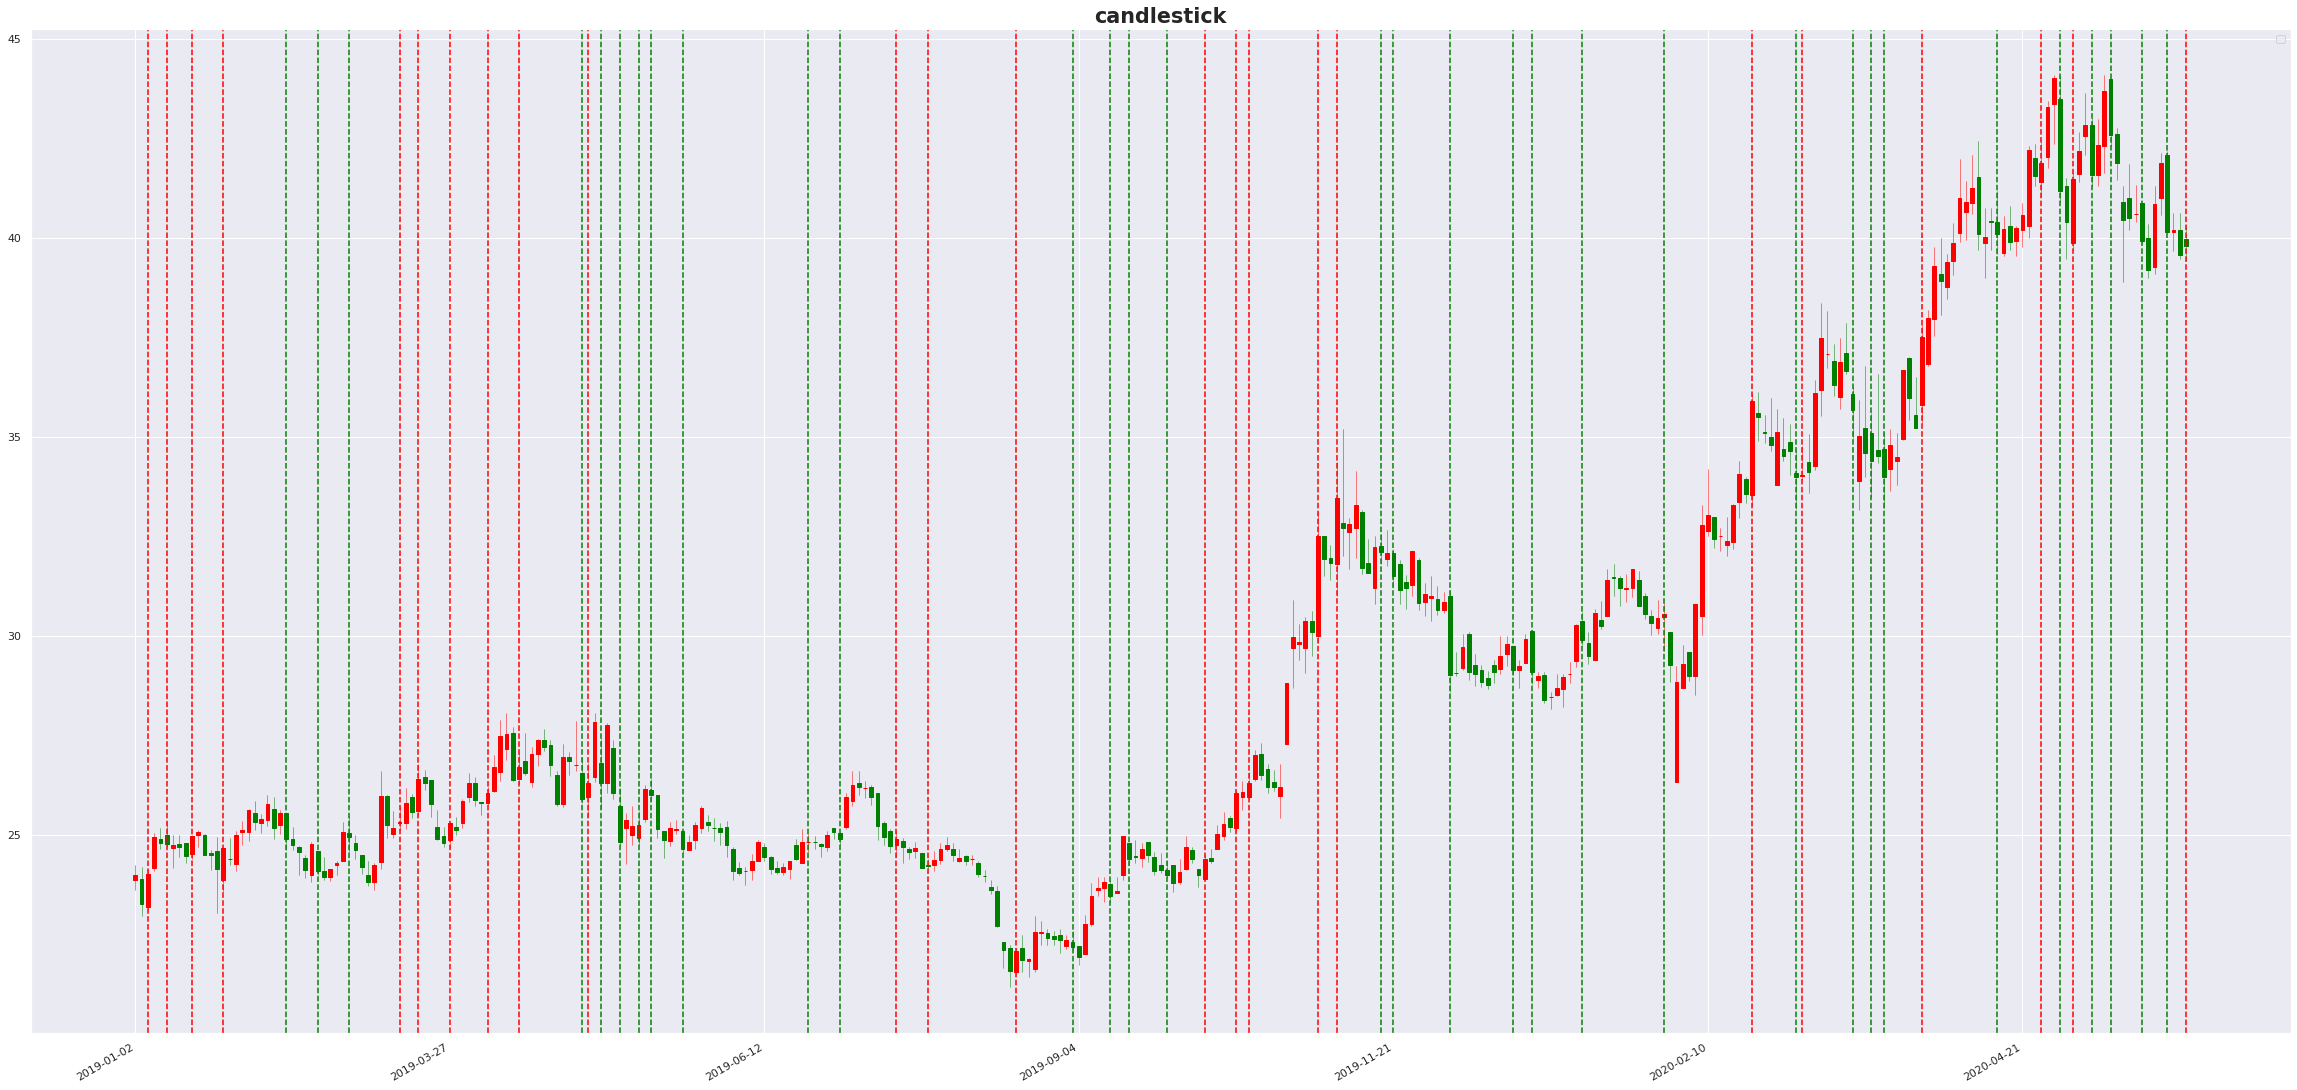

In [15]:
test = QA.QA_fetch_stock_day_adv('000895','2019-01-01','2020-06-01').data
triNetv2(test)
PlotBySe(test)

In [84]:
def weekDF(df):
    #df.reset_index(inplace=True)
    #df.reset_index()

    #df.drop(['code'],axis=1,inplace=True)
    df['date'] = pd.to_datetime(df.index.get_level_values('date'))
    df.set_index("date", inplace=True)
    period = 'W'

    weekly_df = df.resample(period).last()
    weekly_df['open'] = df['open'].resample(period).first()
    weekly_df['high'] = df['high'].resample(period).max()
    weekly_df['low'] = df['low'].resample(period).min()
    weekly_df['close'] = df['close'].resample(period).last()
    weekly_df['volume'] = df['volume'].resample(period).sum()
    weekly_df['amount'] = df['amount'].resample(period).sum()
    weekly_df.reset_index('date',inplace=True)
    return weekly_df

wd = weekDF(test)
wd

,date,open,high,low,close,volume,amount
0,2018-01-07,20.00,20.40,19.68,19.68,1283736.0,2.5764e+09
1,2018-01-14,19.42,19.48,18.18,18.48,1521661.0,2.8551e+09
2,2018-01-21,18.30,18.30,16.56,16.99,1269379.0,2.1934e+09
3,2018-01-28,16.93,17.80,16.64,17.36,921230.0,1.5992e+09
4,2018-02-04,17.21,17.28,15.70,16.25,760527.0,1.2689e+09
5,2018-02-11,15.99,16.31,15.20,15.83,719184.0,1.1435e+09
6,2018-02-18,15.99,18.00,15.95,17.13,648221.0,1.1084e+09
7,2018-02-25,17.25,17.74,17.16,17.41,296250.0,5.1699e+08
8,2018-03-04,17.75,21.45,17.41,20.21,3258373.0,6.3933e+09
9,2018-03-11,20.50,21.74,20.15,20.90,3355801.0,7.0003e+09


In [46]:
def rsiBreak(test):
    rsi = QA.QA_indicator_RSI(test)
    test['RSI9']=rsi.RSI3
    test['RSI12']=rsi.RSI1
    test['RSI26']=rsi.RSI2
    test['MA5']=QA.MA(test.close,5)
    pp_array = [float(close) for close in test.close]
    temp_array = [(price1, price2) for price1, price2 in zip(pp_array[:-1], pp_array[1:])]
    change = list(map(lambda pp: reduce(lambda a, b: round((b - a) / a, 3), pp), temp_array))
    change.insert(0, 0)
    test['change'] = change
    
    
    
    m = np.where(test.RSI9<=20, 1, 0)
    single = []
    for i in range(test.shape[0]):
        if(test.RSI9[i]<=20 and test.close[i]>test.MA5[i] ):
            single.append(1)
        else:
            single.append(0)
    test['single']=single
    return test

In [48]:
rsiBreak(test)
test

,,open,high,low,close,volume,amount,RSI9,MA5,single,RSI12,RSI26,change
date,code,,,,,,,,,,,,
2018-01-02,000977,20.00,20.27,19.82,20.19,330701.0,6.6429e+08,0.0000,NaN,0,0.0000,0.0000,0.000
2018-01-03,000977,20.15,20.40,19.95,20.18,361958.0,7.3012e+08,0.0000,NaN,0,0.0000,0.0000,-0.000
2018-01-04,000977,20.18,20.35,19.83,19.93,318370.0,6.3953e+08,0.0000,NaN,0,0.0000,0.0000,-0.012
2018-01-05,000977,19.95,20.19,19.68,19.68,272707.0,5.4245e+08,0.0000,NaN,0,0.0000,0.0000,-0.013
2018-01-08,000977,19.42,19.48,18.50,18.79,483666.0,9.0984e+08,0.0000,19.754,0,0.0000,0.0000,-0.045
2018-01-09,000977,18.72,18.75,18.52,18.70,189607.0,3.5314e+08,0.0000,19.456,0,0.0000,0.0000,-0.005
2018-01-10,000977,18.77,19.15,18.57,18.94,262826.0,4.9654e+08,17.0842,19.208,0,15.8197,13.3404,0.013
2018-01-11,000977,18.72,19.08,18.18,19.04,347941.0,6.5100e+08,23.2319,19.030,0,21.4669,18.0763,0.005
2018-01-12,000977,18.95,19.06,18.43,18.48,237621.0,4.4456e+08,15.8352,18.790,0,15.2266,13.7121,-0.029


QUANTAXIS>> No handles with labels found to put in legend.
No handles with labels found to put in legend.
/root/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:147: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.


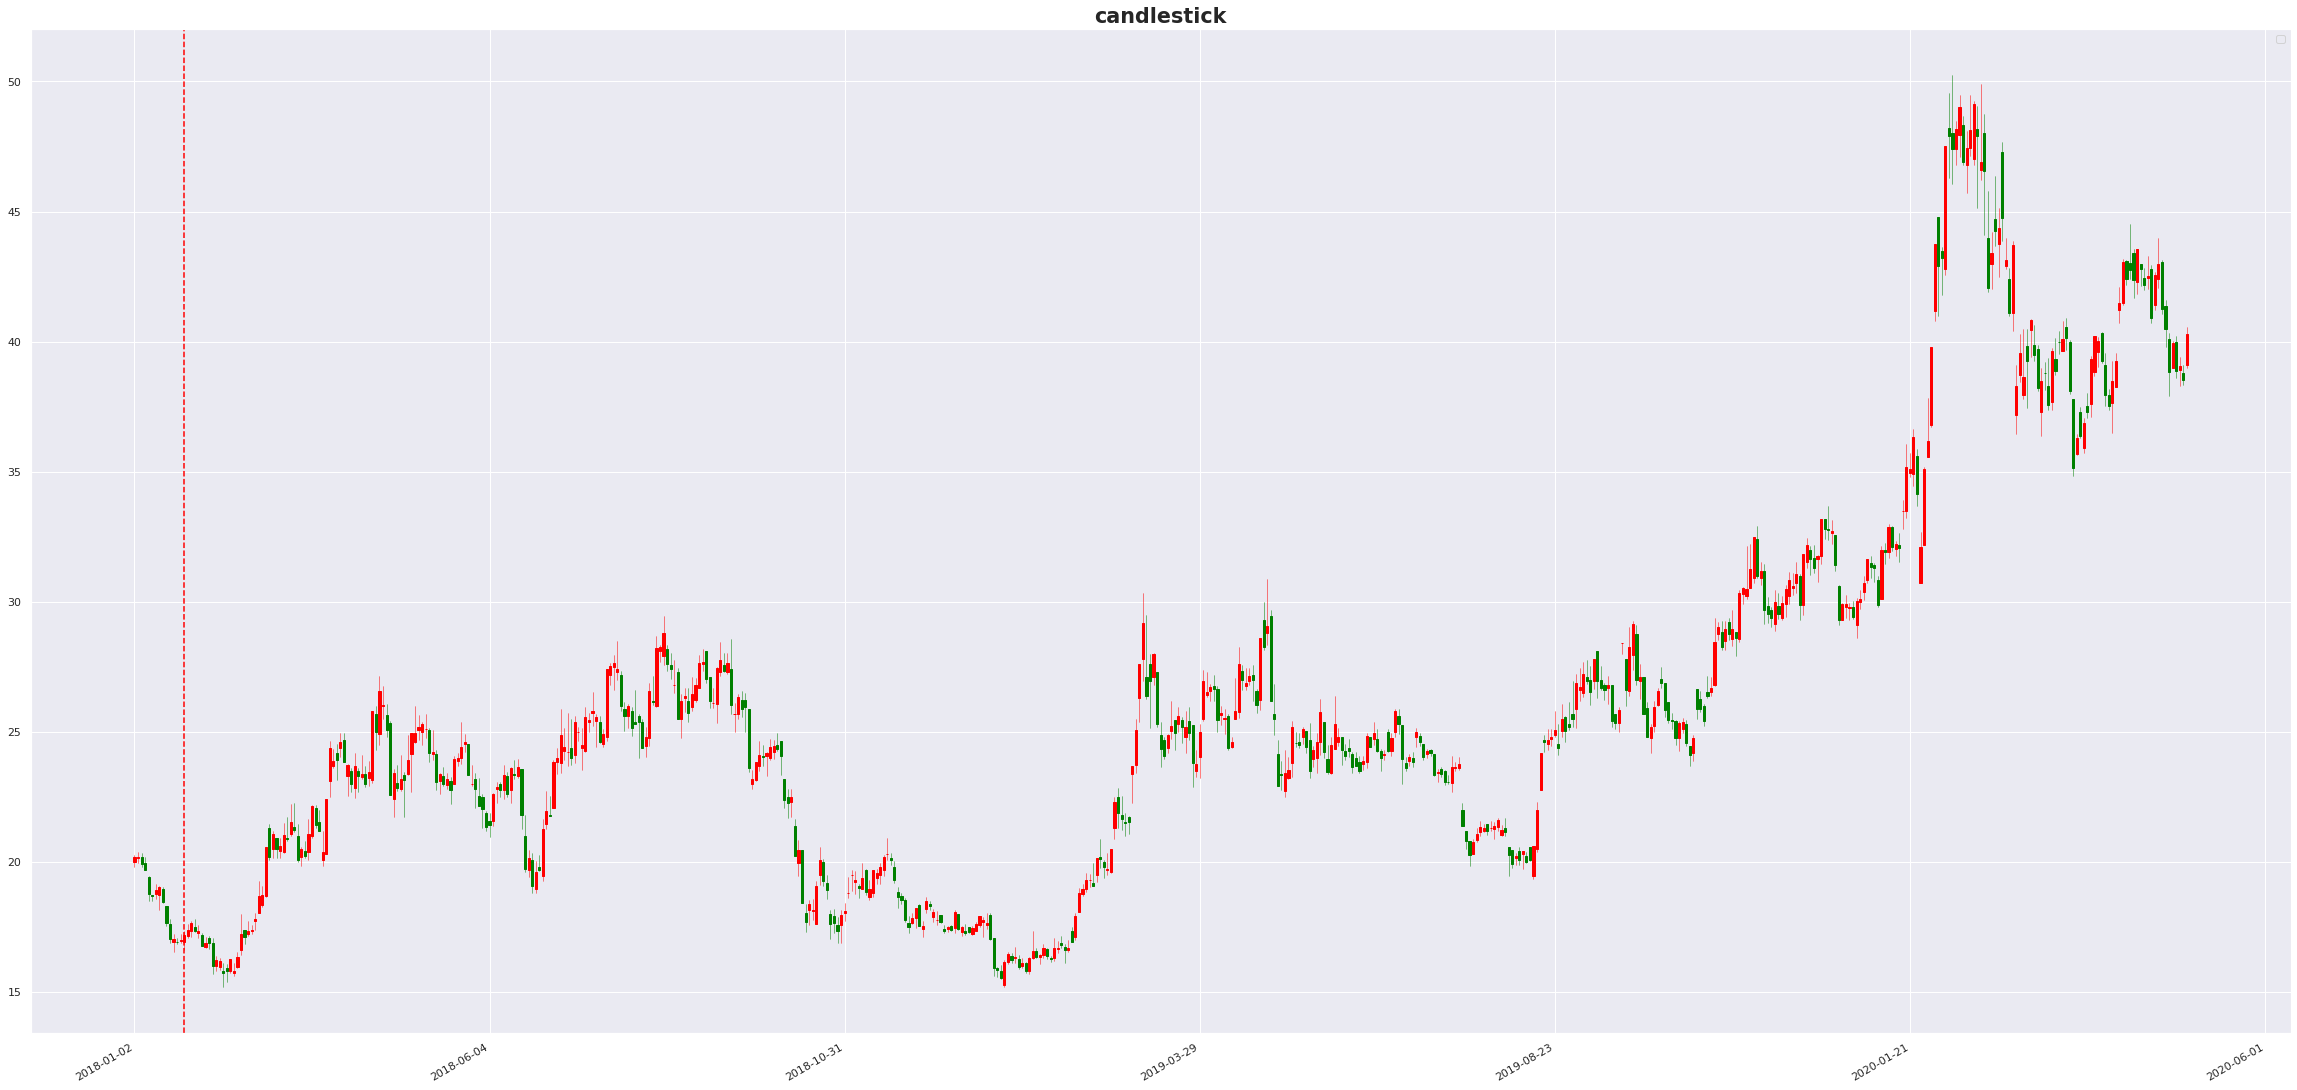

In [45]:
#doubleAvgDay(test)
rsiBreak(test)
PlotBySe(test)

In [90]:
test = QA.QA_fetch_stock_day_adv('601006','2019-01-01','2020-06-01').data
test.isnull().sum().sum()

0

In [96]:
test.index.get_level_values('code')[-1]

'601006'